### Import packages

In [11]:
import os
import glob
import zipfile
import shutil
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import math
import codecs
import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import json
import gensim
from gensim import corpora, models
%matplotlib inline

### Set all important file paths

In [20]:
pwd()

u'/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project'

In [11]:
# Richard path specs

# # At work:
# TEXT_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Text/"
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
# LIBRARY_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Libraries/"

# # At home:
# dict_path = '/Users/Richard/Desktop/Berkeley/w266/'
# input_path = '/Users/Richard/Desktop/Berkeley/w266/'
# output_path = '/Users/Richard/Desktop/Berkeley/w266/'



In [4]:
# Tom path specs

# Tom machine:
TEXT_DIR_LIST = ["T1", "T2", "T3", "T4"]
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
LIBRARY_PATH = "/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/"



### Import a dictionary

Import a bag of words style dictionary for word counting analyses


In [24]:
def get_dictionary(file_path, file_name):
    """Read a standard word list dictionary text file into a list"""
    with open(file_path + file_name, "r") as file:
#         words = [word.lower().rstrip('\n') for word in file]
        words = [word.lower().rstrip() for word in file] # had to strip \r as well on my machine
    return words


## Build a list of files that have valid Q&A sections we want to use

This section reviews all the files and rejects any that do not meet our criteria for use.

In [21]:
# Different possible section headers
CO_PART_HEADERS = ['Company Participants']
OTH_PART_HEADERS = ['Other Participants']
MD_SECTION_HEADERS = ['MANAGEMENT DISCUSSION SECTION', 'Presentation']
QA_SECTION_HEADERS = ['Q&A', 'Questions And Answers', 'QUESTION AND ANSWER SECTION',
                      'QUESTION AND ANSWER SESSION', 'QUESTION-AND-ANSWER SECTION']
DISCLAIMER = ['This transcript may not be 100 percent accurate ']


In [22]:

# New text file format has headers
def remove_header_footers(ts):
    i = 0
    header_footer = []
    # Add all the lines before the first 'Page 1 of n' line
    while ts[i].find('Page') == -1:
#         if ts[i].find('Fixed') != -1:
#             print (ts[1], ts[2])
        header_footer.append(ts[i])
        i += 1
    # Extract the total page number and add lines to strip for all the 
    # 'Page x of n' line
    pages = ts[i]
    pages = pages.split(' ')
    page_num = int(pages[-1])
    for i in range(1, page_num + 1):
        header_footer.append('Page ' + str(i) + ' of ' + str(page_num))
    ts = [line for line in ts if line not in header_footer]
    return ts


def read_transcript(file_path):
    # read in all lines of the transcript
    with open(file_path, "r") as file:
        ts = file.readlines()
        ts = [str(unicode(line, errors = 'ignore')) for line in ts]
        ts = [line.rstrip() for line in ts]
        ts = remove_header_footers(ts)
    return ts


# Find the index value of a full string from a list of possible strings
def find_full_string_index(ts, string_list):
    result = -1
    for i in range(len(string_list)):
        if string_list[i] in ts:
            result = ts.index(string_list[i])
    return result

# Find the index of the disclaimer
def find_disclaimer_index(ts, string_list):
    result = -1
    k = len(ts) - 1
    while True:
        for my_str in string_list:
            if ts[k].find(my_str) != -1:
                result = k
                break
        k -= 1
        if k < 0:
            break
    return result

# Get transcript list indices from a single transcript
def get_basic_parameters(ts):
    call_type = ts[0]
    # check call type
    if call_type.find("Earnings Call") == -1:
        call_type = -1
    else:
        if call_type.find("Fixed") != -1:  # don't want Fixed Income calls
            call_type = -1
            
    co_parts = find_full_string_index(ts,CO_PART_HEADERS)
    oth_parts = find_full_string_index(ts,OTH_PART_HEADERS)
    md = find_full_string_index(ts,MD_SECTION_HEADERS)
    qa = find_full_string_index(ts,QA_SECTION_HEADERS)
    disc = find_disclaimer_index(ts,DISCLAIMER)
    return [call_type, co_parts, oth_parts, md, qa, disc]


In [23]:
# Get the file paths to all files of a specified file type from a given directory
def get_files(file_path, file_type):
    file_list = glob.glob(file_path + "*." + file_type)
    return file_list

def get_files_from_dirs(directory_list, file_type):
    # Read in all the files from subdirectories into a master list
    
    matchfiles = []
    for d in directory_list:
        matchfiles.extend(get_files(LIBRARY_PATH+d+"/",'txt'))    
    return matchfiles

def find_valid_files(file_list):
    '''Scans all the files in the file list and returns a list of those which
       pass all QA checks, and a list of those that do not, with reason why'''
    
    good_files = []
    problems = []

    for path in file_list:
        ts = read_transcript(path)
        params = get_basic_parameters(ts)
        
        errs = ["not equity earnings call",
                "no co participants",
                "no other participants",
                "no mgmt discussion section",
                "no Q&A section",
                "no disclaimer"
                ]
        
        errs_found = []
        for i, err in enumerate(errs):
            if params[i] == -1:
                errs_found.append(err)
        
        if len(errs_found) == 0:
            good_files.append(path)
        else:
            problems.append((errs_found, path, params))

    return good_files, problems


files_to_check = get_files_from_dirs(TEXT_DIR_LIST, "txt")
TextFiles, error_files = find_valid_files(files_to_check)

print "Valid Files found: ", len(TextFiles)
print
print "Files rejected:", len(error_files)
print
err_counts = defaultdict(int)
err_lists = defaultdict(list)
for f in error_files:
    for err in f[0]:
        err_counts[err] += 1
        err_lists[err].append(f[1])

print "Number of files with each type of error (file can have >1 error):"
for err in err_counts:
    print err, err_counts[err]
    print "Files are:"
    for f in err_lists[err]:
        print f

Valid Files found:  3245

Files rejected: 103

Number of files with each type of error (file can have >1 error):
no Q&A section 42
Files are:
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20100806_1_AIG.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20100817_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20101105_1_AIG.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20101110_1_GM.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20101116_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20110517_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20110816_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20111115_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20120221_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20120517_1_WMT.txt
/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/T1/20120816_1_WMT.txt
/Users/seddo

### Pre-processing functions

In [25]:
def remove_square_brackets(my_str):
    return re.sub(r'\[.+?\]', '', my_str)

def remove_square_brackets_transcript(ts):
    return list(map(lambda line: remove_square_brackets(line), ts))


In [26]:
# Find participants on the call
def get_parts(ts, start_index, end_index):
    result = [name[re.search("[a-z]", name.lower()).start():] for name in ts[start_index+1:end_index] if len(name) >= 3]
    # Check for problematic names
    extra_names = []
    for name in result:
        # Find any title after name and remove it
        if name.find(',') != -1:
            name_only = name[:name.find(',')]
            extra_names.append(name_only)
        # Find names with middle initials and remove them
        elif name.find('.') != -1:
            name_only = remove_middle_initials(name)
            if name_only != name:
                extra_names.append(name_only)
    # Find names in extra names with middle initials and remove them
    for name in extra_names:
        if name.find('.') != -1:
            name_only = remove_middle_initials(name)
            if name_only != name:
                extra_names.append(name_only)
    return result + extra_names

# Remove middle initial from a name
def remove_middle_initials(my_str):
    # count = 0
    while True:
        if my_str.find('.') != -1:
            new_my_str = re.sub(r'(\s)([A-Z].)(\s)', r"\1", my_str)
            if new_my_str == my_str:
                break
            else:
                my_str = new_my_str
            # count += 1
            # if count >= 10:
            #     break
        else:
            break
    return my_str


In [27]:
# Find a section of the call
def get_section(ts, start_index, end_index):
    result = ts[start_index+1:end_index]
    result = [line for line in result if line not in ['\x0c']]   # clean the transcript for unnecessary lines
    return result


In [28]:
def get_MD(ts, names, start_index, end_index):

    curr_speaker = ""
    section_header = "MD"
    
    # Create an empty dict for comments by each manager
    pts = {name: "" for name in names}

    # Get the required section
    section = get_section(ts, start_index, end_index)
    
    # Find the first instance of a co_parts speaker
    start_section = 0
    while True:
        if section[start_section] not in names:
            start_section += 1
        else:
            break
        if start_section == len(section):
            start_section = -1
            break

    if start_section == -1:
        pts['No speaker found'] = section_header
    else:
        # Reduce MD Section to management speaking only
        section = section[start_section:]
        # populate comment dict
        for line in section:
            if line in names:
                curr_speaker = line
            elif len(line) != 0:
                pts[curr_speaker] += line + " "

    return pts


In [29]:
# This procedure combines the raw Q&A section into pairs of questions and answers in a dictionary

def get_QA(ts, start_index, end_index):

    pts = {}
    # get the Q&A section
    qa_section = get_section(ts, start_index, end_index)

    q_or_a = None
    currQ = ''
    currA = ''
    
    for line in qa_section:
        line = remove_square_brackets(line)
        if len(line) > 0:                                     # if line is '' then ignore otherwise process the line
            if line == 'Operator':                            # if line is 'Operator' then set everything NULL and ignore
                q_or_a = None
                currQ = ''
                currA = ''
            if line[0] == "<":                                # if Q or A found do something
                if line[0:2] == "<Q":
                    if q_or_a == 'A':                         # if Q found and q_or_a is not NULL then add Q: A to the dictionary
                        pts[currQ[:-1]] = currA[:-1]          # and reset the parameters to NULL
                        currQ = ''
                        currA = ''
                        q_or_a = None    
                    end_qa_tag = line.find(">")
                    currQ += line[end_qa_tag + 3:] + " "      # Concatenate the string after the '>' to the previous string
                    q_or_a = 'Q'                              # Given Q found set q_or_a = 'Q'
                if line[0:2] == "<A":
                    end_qa_tag = line.find(">")             
                    currA += line[end_qa_tag + 3:] + " "      # Concatenate the string after the '>' to the previous string
                    q_or_a = 'A'                              # Given Q found set q_or_a = 'Q'
            else:                                             
                if q_or_a is not None:                        # Other if currently a Q or A just concatenate the string 
                    if q_or_a == 'Q':
                        currQ += line + " "
                    else:
                        currA += line + " "

    if currQ != '' and currA != '':                           # Add last Q: A pair to the dictionary if necessary
        pts[currQ[:-1]] = currA[:-1]

    return pts




### Bespoke cleaning

The following procedures deal with strings with words that have apostrophes, hyphens, slashes and unusual characters in them to help best isolate actual words.

In [30]:
def short_form_replace(my_str):
    """Convert apostrophes in known short-forms in my_string to long-forms"""
    my_str = replace_non_utf8_apostrophes(my_str)
    my_str = re.sub(r'let\'s', "let us", my_str)
    my_str = re.sub(r'Let\'s', "let us", my_str)
    my_str = re.sub(r'won\'t', "will not", my_str)
    my_str = re.sub(r'can\'t', "cannot", my_str)
    my_str = re.sub(r'shan\'t', "shall not", my_str)
    my_str = re.sub(r'Won\'t', "Will not", my_str)
    my_str = re.sub(r'Can\'t', "Cannot", my_str)
    my_str = re.sub(r'Shan\'t', "Shall not", my_str)
    my_str = re.sub(r'n\'t', " not", my_str)
    my_str = re.sub(r'\'ve', " have", my_str)
    my_str = re.sub(r'\'re', " are", my_str)
    my_str = re.sub(r'\'m', " am", my_str)
    my_str = re.sub(r'\'ll', " will", my_str)
    my_str = re.sub(r'\'d', " would", my_str)     # note could also be did or had as well
    my_str = re.sub(r'it\'s', "it is", my_str)
    my_str = re.sub(r'he\'s', "he is", my_str)
    my_str = re.sub(r'she\'s', "she is", my_str)
    my_str = re.sub(r'that\'s', "that is", my_str)
    my_str = re.sub(r'what\'s', "what is", my_str)
    my_str = re.sub(r'here\'s', "here is", my_str)
    my_str = re.sub(r'there\'s', "there is", my_str)
    my_str = re.sub(r'who\'s', "who is", my_str)
    my_str = re.sub(r'It\'s', "It is", my_str)
    my_str = re.sub(r'He\'s', "He is", my_str)
    my_str = re.sub(r'She\'s', "She is", my_str)
    my_str = re.sub(r'Shat\'s', "That is", my_str)
    my_str = re.sub(r'What\'s', "What is", my_str)
    my_str = re.sub(r'Here\'s', "Here is", my_str)
    my_str = re.sub(r'There\'s', "There is", my_str)
    my_str = re.sub(r"Who's", "Who is", my_str)
    return my_str


def apostrophe_s_replace(my_str):
    """Remove 's at the end of words in my_string. Best to run this after short_form_replace()"""
    my_str = re.sub(r"([A-z])\'s", r"\1", my_str)
    return my_str


def hyphen_replace(my_str):
    """Replace hyphens in hyphenated words with a space"""
    my_str = re.sub(r"([A-z])(\-)([A-z])", r"\1 \3", my_str)
    my_str = re.sub(r"([A-z])(\-)(\s)([A-z])", r"\1 \4", my_str)
    return my_str


def forward_slash_replace(my_str):
    """Replace forward slashes in combined words with a space."""
    my_str = re.sub(r"([A-z])(/)([A-z])", r"\1 \3", my_str)
    my_str = my_str.replace(')/', ' ')
    my_str = my_str.replace('/(', ' ')
    return my_str


def replace_apostrophes(my_str):
    """Tidy up my_string for all apostrophe-related issues."""
    my_str = replace_non_utf8_apostrophes(my_str)
    my_str = short_form_replace(my_str)
    my_str = apostrophe_s_replace(my_str)
    return my_str


def clean_text(my_str):
    """Clean my_string for all known string issues to prepare for text analysis"""
    my_str = replace_apostrophes(my_str)
    my_str = hyphen_replace(my_str)
    my_str = forward_slash_replace(my_str)
    return my_str


def replace_non_utf8_apostrophes(my_str):
    """Replace most common non-utf-8 apostrophes with utf-8 apostrophes"""
    apostrophes = [str(b'\xe2\x80\x98'), str(b'\xe2\x80\x99')]
    for i in range(len(my_str)):
        if str(my_str[i].encode('utf-8')) in apostrophes:
            my_str = my_str[:i] + "'" + my_str[i+1:]
    return my_str



#### Example

### Tokenization

In [31]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

### Stop Words

In [32]:
# Import stop words list
stop_words = get_dictionary(LIBRARY_PATH,'stop_words.txt')

In [33]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/seddont/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
from nltk.corpus import stopwords

In [35]:
# Create English stop words list from NLTK
nltk_stop_words = stopwords.words('english')

In [36]:
stop_words = sorted(list(set(stop_words + nltk_stop_words)))

### Stemming

In [37]:
from nltk.stem.porter import PorterStemmer

### Vectorize the word list counts


In [38]:
def vectorize_word_list_counts(words, word_list):
    """Count the frequency of words in a document from a word list"""
    count_vector = [words.count(word) for word in sorted(word_list)]
    total_count = sum(count_vector)
    if total_count != 0:
        count_vector = [float(count)/total_count for count in count_vector]
    return count_vector


### Scriptedness pre-processing a document

In [39]:
def scriptedness_pre_process_document(doc):
    tokenizer = RegexpTokenizer(r'\w+')  # This finds letters only and breaks things up at each non-letters character
    porter_stemmer = PorterStemmer()
    lower_doc = doc.lower()
    clean_lower_doc = remove_square_brackets(lower_doc)
    clean_doc = clean_text(clean_lower_doc)
    tokens = tokenizer.tokenize(clean_doc)
    stopped_tokens = tokens # no stopping
    stemmed_tokens = [porter_stemmer.stem(i) for i in stopped_tokens]
    count_vector = vectorize_word_list_counts(stemmed_tokens, function_words)
    return count_vector


### Scriptedness makes use of Cosine Similarity

In [40]:
def cosine_similarity(v1, v2):
    """Returns the cosine similarity score for two equal length vectors of numbers.
    To compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)."""
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x, y = v1[i], v2[i]
        sumxx += x * x
        sumyy += y * y
        sumxy += x * y
    if math.sqrt(sumxx * sumyy) !=0:
        result = round(sumxy/math.sqrt(sumxx * sumyy),6)
    else:
        result = 0
    return result


In [41]:
# This gets the average similarity for one comment, i.e. full MD section, and all the answers separately
def get_avg_score(comment, answers):
    scores = []
    v1 = comment
    for v2 in answers:
        scores.append(cosine_similarity(v1, v2))
    avg_score = round(sum(scores)/len(scores),6)
    return avg_score


In [42]:
def get_filename_components(file_path, i):
    file_name_and_ext = os.path.basename(file_path)
    name_only = os.path.splitext(file_name_and_ext)[0]
    date, file_num, ticker = name_only.split("_")
    
#     file_path = file_path.split('_')
#     print (i, file_path)
#     date = file_path[0][-8:]
#     file_num = file_path[1]
#     ticker = file_path[2][:-4]
    return (ticker, date, file_num)
    

### Perform Scriptedness Analysis

In [42]:
a = 3
b = 6
print b % a

0


In [43]:
function_words = get_dictionary(LIBRARY_PATH,'function_words.txt')

results = {}
i = 0
report_every = 100
start_time = time.time()

for f in TextFiles[:]:
    
    (ticker, date, file_num) = get_filename_components(f, i)

    ts = read_transcript(f)
    
    if 'Earnings Call' in ts[0]:
        # Get Company Participants
        start = find_full_string_index(ts, CO_PART_HEADERS)
        end = find_full_string_index(ts, OTH_PART_HEADERS) - 1
        if start != -1 and end != -2: 
            co_part_names = get_parts(ts, start, end)

            # Get MD Section
            start = find_full_string_index(ts, MD_SECTION_HEADERS)
            end = find_full_string_index(ts, QA_SECTION_HEADERS) - 1
            MD = get_MD(ts, co_part_names, start, end)
            comments = [comment for comment in MD.values() if len(comment) > 20]
            comment = ' '.join(comments)
            comment = scriptedness_pre_process_document(comment)

            # Get QA Section
            start = find_full_string_index(ts, QA_SECTION_HEADERS)
            end = find_disclaimer_index(ts, DISCLAIMER)
            QA = get_QA(ts, start, end)    
            # get the answers with a condition to ensure the answer is of at least some length
            answers = [answer for answer in QA.values() if len(answer) > 20]
            answers = [scriptedness_pre_process_document(answer) for answer in answers]
            
            

            if date not in results.keys():
                results[date] = {}

            if len(answers) > 0:
                results[date][ticker] = get_avg_score(comment, answers)
        i += 1
        if i % report_every == 0:
            print "Processed ", i, "in ", time.time() - start_time, "seconds"
            
            

Processed  100 in  33.0836439133 seconds
Processed  200 in  68.7751340866 seconds
Processed  300 in  101.393887997 seconds
Processed  400 in  136.977929115 seconds
Processed  500 in  170.831770897 seconds
Processed  600 in  206.512324095 seconds
Processed  700 in  237.868125916 seconds
Processed  800 in  270.91129303 seconds
Processed  900 in  306.931483984 seconds
Processed  1000 in  340.798830032 seconds
Processed  1100 in  374.389487028 seconds
Processed  1200 in  406.925538063 seconds
Processed  1300 in  440.434200048 seconds
Processed  1400 in  468.847615004 seconds
Processed  1500 in  504.055380106 seconds
Processed  1600 in  537.961705923 seconds
Processed  1700 in  571.062612057 seconds
Processed  1800 in  604.028934002 seconds
Processed  1900 in  636.496877909 seconds
Processed  2000 in  670.792009115 seconds
Processed  2100 in  703.305896997 seconds
Processed  2200 in  736.161278009 seconds
Processed  2300 in  768.322506905 seconds
Processed  2400 in  802.413435936 seconds
Pr

In [44]:
results

{'20100730': {'AEP': 0.700156,
  'CVX': 0.58198,
  'MET': 0.59171,
  'MRK': 0.747433,
  'SPG': 0.60501,
  'WY': 0.532411},
 '20100803': {'BHI': 0.629955,
  'DOW': 0.65646,
  'DUK': 0.578824,
  'EMR': 0.519417,
  'ETR': 0.600502,
  'MA': 0.614056,
  'NYX': 0.51326,
  'PCLN': 0.656028,
  'PFE': 0.360584,
  'PG': 0.336925},
 '20100804': {'CHTR': 0.671091,
  'DVN': 0.625642,
  'FOXA': 0.523457,
  'TWX': 0.739454},
 '20100805': {'AGN': 0.60002, 'ALL': 0.510867, 'MDLZ': 0.590864},
 '20100810': {'DIS': 0.72788},
 '20100811': {'CSCO': 0.455655},
 '20100812': {'GM': 0.56016, 'HSH': 0.576464},
 '20100816': {'LOW': 0.637366},
 '20100817': {'HD': 0.663928},
 '20100818': {'TGT': 0.744857},
 '20100819': {'DELL': 0.63952, 'HPQ': 0.705189},
 '20100824': {'MDT': 0.673229},
 '20100901': {'HNZ': 0.577725},
 '20100903': {'CPB': 0.460749},
 '20100916': {'FDX': 0.72698, 'ORCL': 0.712935},
 '20100923': {'NKE': 0.583516},
 '20100928': {'WBA': 0.621681},
 '20100930': {'ACN': 0.597531, 'NEE': 0.496709},
 '20101

In [46]:
with open("cosine_sim_results.txt", "w") as f:
    f.write(json.dumps(results))

In [47]:
with open("cosine_sim_results.txt", "r") as f:
    results_back = json.loads(f.read())

In [48]:
results_back

{u'20100730': {u'AEP': 0.700156,
  u'CVX': 0.58198,
  u'MET': 0.59171,
  u'MRK': 0.747433,
  u'SPG': 0.60501,
  u'WY': 0.532411},
 u'20100803': {u'BHI': 0.629955,
  u'DOW': 0.65646,
  u'DUK': 0.578824,
  u'EMR': 0.519417,
  u'ETR': 0.600502,
  u'MA': 0.614056,
  u'NYX': 0.51326,
  u'PCLN': 0.656028,
  u'PFE': 0.360584,
  u'PG': 0.336925},
 u'20100804': {u'CHTR': 0.671091,
  u'DVN': 0.625642,
  u'FOXA': 0.523457,
  u'TWX': 0.739454},
 u'20100805': {u'AGN': 0.60002, u'ALL': 0.510867, u'MDLZ': 0.590864},
 u'20100810': {u'DIS': 0.72788},
 u'20100811': {u'CSCO': 0.455655},
 u'20100812': {u'GM': 0.56016, u'HSH': 0.576464},
 u'20100816': {u'LOW': 0.637366},
 u'20100817': {u'HD': 0.663928},
 u'20100818': {u'TGT': 0.744857},
 u'20100819': {u'DELL': 0.63952, u'HPQ': 0.705189},
 u'20100824': {u'MDT': 0.673229},
 u'20100901': {u'HNZ': 0.577725},
 u'20100903': {u'CPB': 0.460749},
 u'20100916': {u'FDX': 0.72698, u'ORCL': 0.712935},
 u'20100923': {u'NKE': 0.583516},
 u'20100928': {u'WBA': 0.621681},


Mean sim score is 0.607857327524
SD of sim scores is 0.155181479641


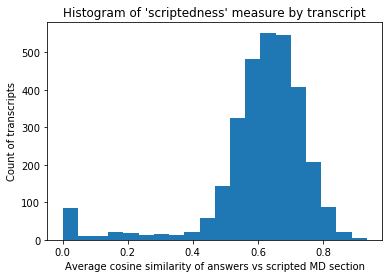

In [49]:
# Simple analysis and distribution plot for similarities

# Just build a vector of similarity scores
sim_scores = []
for day_record in results:
    for co_id in results[day_record]:
        sim_scores.append(results[day_record][co_id])
        
print "Mean sim score is", np.mean(sim_scores)
print "SD of sim scores is", np.std(sim_scores)

plt.hist(sim_scores, bins = 20)
plt.xlabel("Average cosine similarity of answers vs scripted MD section")
plt.ylabel("Count of transcripts")
plt.title("Histogram of 'scriptedness' measure by transcript")

# LDA Approach

http://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html

### Install packages

In [ ]:
#!pip install --index-url=http://pypi.python.org/simple/ --trusted-host pypi.python.org gensim

In [112]:
#!pip install --index-url=http://pypi.python.org/simple/ --trusted-host pypi.python.org smart_open

In [9]:
# import gensim

### Constructing a document-term matrix

The result of our cleaning stage is `texts`, a tokenized, stopped and stemmed list of words from a list of documents. 

To generate an LDA model, we need to understand how frequently each term occurs within each document. To do that, we need to construct a document-term matrix with a package called gensim:

In [43]:
def testLDA_pre_process_document(doc):
    tokenizer = RegexpTokenizer(r'\w+')  # This finds letters only and breaks things up at each non-letters character
    porter_stemmer = PorterStemmer()
    lower_doc = doc.lower()
    clean_lower_doc = remove_square_brackets(lower_doc)
    clean_doc = clean_text(clean_lower_doc)
    tokens = tokenizer.tokenize(clean_doc)
    stopped_tokens = [t for t in tokens if not t in stop_words]
    stemmed_tokens = [porter_stemmer.stem(i) for i in stopped_tokens]
    return stemmed_tokens

### Learn topic model, apply to Q&A pairs and evaluate similarity of Qs and As

In [44]:
# Build a dictionary of Q&A

function_words = get_dictionary(LIBRARY_PATH,'function_words.txt')

texts = []
i = 0
report_every = 100
start_time = time.time()

MIN_TOKENS_NEEDED = 20  # minimum length that the Question and the Answer must
                        # both have to be considered for topic modelling and similarity

rawtext_qa = defaultdict(dict)
qa_pairs = defaultdict(dict)

for f in TextFiles[:]:
    
    (ticker, date, file_num) = get_filename_components(f, i)
    
    file_id = ticker+"_"+date

    ts = read_transcript(f)
    
    # Get Company Participants
    start = find_full_string_index(ts, CO_PART_HEADERS)
    end = find_full_string_index(ts, OTH_PART_HEADERS) - 1
    if start != -1 and end != -2: 
        co_part_names = get_parts(ts, start, end)

        # Get QA Section
        start = find_full_string_index(ts, QA_SECTION_HEADERS)
        end = find_disclaimer_index(ts, DISCLAIMER)
        QA = get_QA(ts, start, end)

        # get the QA pairs with a condition to ensure both of at least some length
        q_number = 0
        for question in QA:
            if (len(question) > MIN_TOKENS_NEEDED and
                len(QA[question]) > MIN_TOKENS_NEEDED):

                procd_question = testLDA_pre_process_document(question)
                procd_answer = testLDA_pre_process_document(QA[question])

                # store indexed rawtext for easier inspection later
                rawtext_qa[file_id][q_number] = (question, QA[question])

                # store indexed processed tokens to feed model and perform inference
                qa_pairs[file_id][q_number] = (procd_question, procd_answer)
                q_number +=1 


        answers = [answer for answer in QA.values() if len(answer) > 20]
        answers = [testLDA_pre_process_document(answer) for answer in answers]

        texts.extend(answers)
    i += 1
    if i % report_every == 0:
        print "Processed ", i, "transcripts in ", time.time() - start_time, "seconds"
print "Finished all", i, "transcripts in ", time.time() - start_time, "seconds"

Processed  100 transcripts in  23.1319549084 seconds
Processed  200 transcripts in  47.6172258854 seconds
Processed  300 transcripts in  69.6726689339 seconds
Processed  400 transcripts in  92.4927008152 seconds
Processed  500 transcripts in  115.463982821 seconds
Processed  600 transcripts in  138.192358971 seconds
Processed  700 transcripts in  158.68459487 seconds
Processed  800 transcripts in  180.827924013 seconds
Processed  900 transcripts in  203.21969986 seconds
Processed  1000 transcripts in  226.122131824 seconds
Processed  1100 transcripts in  247.88625598 seconds
Processed  1200 transcripts in  269.397672892 seconds
Processed  1300 transcripts in  292.477187872 seconds
Processed  1400 transcripts in  308.71825695 seconds
Processed  1500 transcripts in  333.123881817 seconds
Processed  1600 transcripts in  355.869658947 seconds
Processed  1700 transcripts in  379.039839983 seconds
Processed  1800 transcripts in  400.585964918 seconds
Processed  1900 transcripts in  422.62855

In [65]:
# Store the processed tokens in qa_pairs
with open("qa_pairs_found.txt", "w") as f:
    f.write(json.dumps(qa_pairs))

In [45]:
# Also store the rawtext pairs, for easier inspection later
with open("rawtext_qa_found.txt", "w") as f:
    f.write(json.dumps(rawtext_qa))

In [66]:
with open("qa_pairs_found.txt", "r") as f:
    qa_pairs = json.loads(f.read())

In [46]:
with open("rawtext_qa_found.txt", "r") as f:
    rawtext_qa = json.loads(f.read())

In [8]:
# Assemble a unified training texts list from all the qualifying processed Q&A pairs found
texts = []
for file_id in qa_pairs:
    for q_number in qa_pairs[file_id]:
        question, answer = qa_pairs[file_id][q_number]
        texts.append(question)
        texts.append(answer)

In [9]:
for t in texts[:10]:
    print t

[u'right', u'kind', u'give', u'us', u'idea', u'think', u'might', u'happen', u'term', u'capac', u'price', u'northeast', u'result', u'sens', u'mean', u'know', u'kind', u'foggi', u'right']
[u'well', u'mitig', u'take', u'place', u'leo', u'went', u'detail', u'go', u'quarter', u'market', u'price', u'depress', u'market', u'mitig', u'bid', u'anywher', u'75', u'80', u'newbuild', u'cost', u'bid', u'logic', u'go', u'increas', u'capac', u'price']
[u'right', u'sens', u'much', u'mayb', u'preliminari']
[u'think', u'preliminari']
[u'make', u'sure', u'year', u'number', u'14', u'15', u'hedg', u'piec', u'effect', u'midwest', u'plant', u'plu', u'kind', u'indian', u'point', u'contract', u'con', u'ed', u'fair', u'represent', u'mix', u'captur', u'far']
[u'ye', u'major', u'ye']
[u'great', u'secondli', u'comment', u'briefli', u'effort', u'renew', u'frp', u'louisiana', u'seem', u'suggest', u'potenti', u'new', u'rate', u'case', u'file', u'state']
[u'okay', u'gari', u'ye', u'made', u'last', u'file', u'three', u'y

In [12]:
# Convert the texts from all the Questions and Answers into integer form
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [50]:
# Store the corpus to file for recreating model later if wanted
with open("corpus.txt", "w") as f:
    f.write(json.dumps(corpus))

In [51]:
with open("corpus.txt", "r") as f:
    corpus = json.loads(f.read())

In [11]:
# Fit the LDA model

start_time = time.time()
print "fitting model"
# Fit LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=30, id2word = dictionary, passes=10)
print "model fitting took", time.time() - start_time, "seconds"

fitting model
model fitting took 2184.29262018 seconds


In [14]:
# Save the learned model to file
ldamodel.save(LIBRARY_PATH + "saved_models/full_model_" + str(int(time.time())))

In [5]:
# Reload a previously saved model

MODEL_ID = "1512331260"

ldamodel = gensim.models.ldamodel.LdaModel.load(LIBRARY_PATH + "saved_models/full_model_"+MODEL_ID)

In [13]:
# Display top 10 terms for each topic, with intrinsic UMass measure
# of coherence
ldamodel.top_topics(corpus = corpus, coherence = "u_mass", topn = 10)

[([(0.035155439077962182, u'see'),
   (0.030392358471697398, u'think'),
   (0.024503706239780539, u'year'),
   (0.023365690599278493, u'busi'),
   (0.019863051455855239, u'growth'),
   (0.016266719123505323, u'good'),
   (0.015334786915498375, u'continu'),
   (0.012536336719114268, u'market'),
   (0.012272844872590477, u'look'),
   (0.010928470529804408, u'go')],
  -1.1183499429095394),
 ([(0.027828297760335585, u'think'),
   (0.023267012300983932, u'continu'),
   (0.021161599290783758, u'invest'),
   (0.019486647621115388, u'busi'),
   (0.018241494072681174, u'us'),
   (0.017687442903993569, u'look'),
   (0.016169571037898935, u'make'),
   (0.016024663049000281, u'opportun'),
   (0.015261097798074462, u'realli'),
   (0.01446260641309699, u'go')],
  -1.1920355726189669),
 ([(0.058800741840404354, u'think'),
   (0.045661398502497431, u'go'),
   (0.027257272219791066, u'get'),
   (0.024209300453854967, u'thing'),
   (0.019858552771524578, u'know'),
   (0.018193796574426154, u'right'),
  

In [14]:
# Display the coherence and topics in a little more readable form
scored_topics = ldamodel.top_topics(corpus = corpus, coherence = "u_mass", topn = 10)
for t in scored_topics:
    print
    print "U_mass Coherence is ", "{:3.2f}".format(t[1])
    print "Top 10 tokens in topic are:"
    for token_tuple in t[0]:
        print "{:10}{:3.2f}".format(token_tuple[1], token_tuple[0])


U_mass Coherence is  -1.12
Top 10 tokens in topic are:
see       0.04
think     0.03
year      0.02
busi      0.02
growth    0.02
good      0.02
continu   0.02
market    0.01
look      0.01
go        0.01

U_mass Coherence is  -1.19
Top 10 tokens in topic are:
think     0.03
continu   0.02
invest    0.02
busi      0.02
us        0.02
look      0.02
make      0.02
opportun  0.02
realli    0.02
go        0.01

U_mass Coherence is  -1.27
Top 10 tokens in topic are:
think     0.06
go        0.05
get       0.03
thing     0.02
know      0.02
right     0.02
lot       0.02
look      0.02
say       0.02
one       0.02

U_mass Coherence is  -1.31
Top 10 tokens in topic are:
littl     0.05
bit       0.04
mayb      0.04
like      0.03
us        0.03
kind      0.03
think     0.03
give      0.02
talk      0.02
thank     0.02

U_mass Coherence is  -1.72
Top 10 tokens in topic are:
quarter   0.18
first     0.04
fourth    0.03
second    0.02
third     0.02
inventori 0.02
last      0.02
season    0.01


In [ ]:
# Can now apply model to each question and answer pair, and calculate 
# similarity.  Going to use Hellinger distance rather than cosine similarity
# as we are comparing probability distributions.  Could also compare K-L.
# Hellinger is symmetric while K-L is not. 
# For Hellinger Distance 0 = max similarity, 1 = min similarity

In [16]:
from gensim.matutils import hellinger

hellinger_sims = defaultdict(dict)
kl_sims = defaultdict(dict)

start_time = time.time()
i = 0
report_every = 5000

for file_id in qa_pairs:
    for q_number in qa_pairs[file_id]:
        question, answer = qa_pairs[file_id][q_number]
        q_bow = dictionary.doc2bow(question)
        a_bow = dictionary.doc2bow(answer)
        lda_q_bow = ldamodel[q_bow]
        lda_a_bow = ldamodel[a_bow]
        hellinger_sims[file_id][q_number] = hellinger(lda_q_bow, lda_a_bow)
        i += 1
        if i % report_every == 0:
            print "Processed ", i, "pairs in", time.time() - start_time
print "Finished in", time.time() - start_time

Processed  5000 pairs in 13.0588459969
Processed  10000 pairs in 28.0201179981
Processed  15000 pairs in 41.2103149891
Processed  20000 pairs in 56.5965819359
Processed  25000 pairs in 71.0270149708
Processed  30000 pairs in 84.2825219631
Processed  35000 pairs in 97.763561964
Processed  40000 pairs in 111.067982912
Processed  45000 pairs in 124.472028017
Processed  50000 pairs in 137.548304081
Processed  55000 pairs in 151.719196081
Processed  60000 pairs in 168.372379065
Processed  65000 pairs in 181.628458977
Finished in 188.396353006


In [90]:
# Store the corpus to file for recreating model later if wanted
with open("hell_sims.txt", "w") as f:
    f.write(json.dumps(hellinger_sims))

## Restoring from a saved state

Since training the models and processing the text is quite time consuming, it's useful to be able to restore a saved model.  Gensim makes saving and restoring a model easy, but we will often want to also be able to look at the data associated with that model.  This data may not always be the same, because we may apply different preprocessing to the raw transcript text to test the impact of that on the quality of the models.

We also may want to generate multiple models from the same processed set of data with different LDA hyperparameters (e.g. number of topics) so the same inpiut data might be associated with multiple LDA models.

To make this easy during experimentation this is a class that recovers a saved state from files on disk.  The state is specified by a dictionary of files so it is very easy to handle any combination of data and models (as long as we kept track in the first place of what data created what model).

In [100]:
class Saved_state():
    '''Represents a saved state that includes an LDA model and the data used to create it.
    
       Instantiated with a saved_model_dict that locates the files to 
       recreate the saved state and includes a description.
       
       Dictionary needs to contain:
       
       model_files
       qa_pairs_file
       raw_qa_text_file
       corpus_file
       hellinger_file
       state_description
       '''
    def __init__(self, saved_state_dict):
        
        self.ldamodel = gensim.models.ldamodel.LdaModel.load(saved_state_dict["model_files"])
        
        with open(saved_state_dict["qa_pairs_file"], "r") as f:
            self.qa_pairs = json.loads(f.read())
            
        with open(saved_state_dict["raw_qa_text_file"], "r") as f:
            self.raw_qa_text = json.loads(f.read())
            
        with open(saved_state_dict["corpus_file"], "r") as f:
            self.corpus = json.loads(f.read())
            
        with open(saved_state_dict["hellinger_file"], "r") as f:
            self.hellinger_sims = json.loads(f.read())
            
        self.state_description = saved_state_dict["state_description"]

In [101]:
saved_state_dict = {"model_files": LIBRARY_PATH + "saved_models/full_model_1512331260",
                    "qa_pairs_file": LIBRARY_PATH + "qa_pairs_found.txt", 
                    "raw_qa_text_file": LIBRARY_PATH + "rawtext_qa_found.txt", 
                    "corpus_file": LIBRARY_PATH + "corpus.txt",
                    "hellinger_file": LIBRARY_PATH + "hell_sims.txt",
                    "state_description": "First model using full text.  30 topics."}

In [102]:
saved = Saved_state(saved_state_dict)

In [103]:
# Restoring saved state

ldamodel = saved.ldamodel
qa_pairs= saved.qa_pairs
raw_qa_text = saved.raw_qa_text
corpus = saved.corpus
hellinger_sims = saved.hellinger_sims

print "Restored", saved.state_description

Restored First model using full text.  30 topics.


## Exploring topic similarities

Mean similarity 0.481602527366
SD similarity 0.121899125561


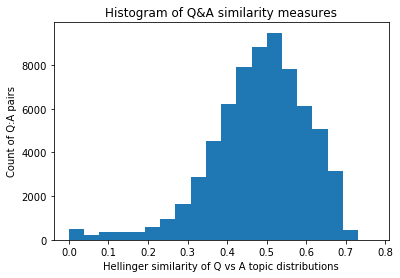

In [104]:
# Create a vector for all the similarity scores
all_sims = []
for file_id in qa_pairs:
    for q_number in qa_pairs[file_id]:
        all_sims.append((hellinger_sims[file_id][q_number],(file_id, q_number)))

sim_vals = [v[0] for v in all_sims]
print "Mean similarity", np.mean(sim_vals)
print "SD similarity", np.std(sim_vals)

plt.hist(sim_vals, bins = 20)
plt.xlabel("Hellinger similarity of Q vs A topic distributions")
plt.ylabel("Count of Q:A pairs")
plt.title("Histogram of Q&A similarity measures")

In [105]:
from operator import itemgetter
all_sims.sort(key=itemgetter(0))
all_sims

[(0.0, (u'LMT_20110426', u'4')),
 (0.0, (u'UTX_20141021', u'34')),
 (0.0, (u'BA_20160727', u'18')),
 (7.850462293418876e-17, (u'XOM_20110728', u'11')),
 (1.1102230246251565e-16, (u'BAX_20130124', u'14')),
 (1.5700924586837752e-16, (u'KMI_20161019', u'34')),
 (1.5700924586837752e-16, (u'NYX_20130430', u'0')),
 (2.3551386880256624e-16, (u'UPS_20130425', u'15')),
 (2.3551386880256624e-16, (u'UPS_20140130', u'24')),
 (2.3551386880256624e-16, (u'BA_20130724', u'41')),
 (2.3551386880256624e-16, (u'BA_20120425', u'24')),
 (2.3551386880256624e-16, (u'WMB_20150430', u'43')),
 (3.1401849173675503e-16, (u'KHC_20170803', u'18')),
 (3.1401849173675503e-16, (u'LMT_20101019', u'1')),
 (3.1401849173675503e-16, (u'BA_20140723', u'10')),
 (3.925231146709438e-16, (u'KO_20150210', u'4')),
 (3.925231146709438e-16, (u'BA_20111026', u'49')),
 (3.925231146709438e-16, (u'BA_20120725', u'19')),
 (3.925231146709438e-16, (u'BA_20150128', u'19')),
 (4.710277376051325e-16, (u'LMT_20151020', u'0')),
 (4.710277376051

In [106]:
# Display the closest n based on distance between q and a

n = 3
for record in all_sims[:n]:
    print
    print "Hellinger Distance of topics is {:4.3f}".format(record[0])
    q_text, a_text = rawtext_qa[record[1][0]][record[1][1]]
    print "Question:"
    print q_text
    print "Answer:"
    print a_text


Hellinger Distance of topics is 0.000
Question:
Good morning, gentlemen.
Answer:
Good morning, Carter.

Hellinger Distance of topics is 0.000
Question:
Hey, good morning, gentlemen.
Answer:
Hey, Carter. Good morning.

Hellinger Distance of topics is 0.000
Question:
Hey, good morning gentlemen.
Answer:
Hey, Carter. Good morning.


In [107]:
# Display the furthest n based on distance between q and a

n = 3
for record in all_sims[-n:]:
    print
    print "Hellinger Distance of topics is {:4.3f}".format(record[0])
    q_text, a_text = rawtext_qa[record[1][0]][record[1][1]]
    print "Question:"
    print q_text
    print "Answer:"
    print a_text


Hellinger Distance of topics is 0.756
Question:
That's great. That's helpful. And my follow-up goes back to some of the earlier questions. Does the emergence of the Woodford oil opportunity in the Mississippi Lime area, is that meaningful enough where it reduces your appetite for considering or adding oil resource via acquisition from some new play elsewhere?
Answer:
Well, we're always going be very disciplined I think. I'll just try that if we're looking at any acquisitions. And so we're going to I think continue to look to see if there are any meaningful. But obviously we haven't made any deals yet because we're being very disciplined from a value standpoint. I think it's always in our best interest to look. But we're certainly excited that this adds a lot of strength to our internal oil growth story as well. I wouldn't say we're going to stop looking because we always look to see if there's something meaningful out there but it certainly gives us a lot more confidence on our intern

In [108]:
n = 3
for record in all_sims[-n:]:
    print record

(0.7556969663730059, (u'DVN_20130807', u'12'))
(0.7592362675216724, (u'LOW_20150225', u'14'))
(0.7697542404092744, (u'C_20130715', u'54'))


In [109]:
question, answer = qa_pairs['LMT_20110426']['4']
print question
print answer
q_bow = dictionary.doc2bow(question)
a_bow = dictionary.doc2bow(answer)
lda_q_bow = ldamodel[q_bow]
lda_a_bow = ldamodel[a_bow]
print lda_q_bow
print lda_a_bow

[u'good', u'morn', u'gentlemen']
[u'good', u'morn', u'carter']
[(12, 0.75833333333333297)]
[(12, 0.75833333333333297)]


In [110]:
print ldamodel.print_topic(12, topn = 7)

0.233*"good" + 0.143*"morn" + 0.066*"2017" + 0.037*"thank" + 0.033*"hi" + 0.027*"hey" + 0.027*"capex"


Why does the topic probabilities not sum to 1?  Apparently because it automatically filters out below a certain minimum probability.  See https://groups.google.com/forum/#!topic/gensim/F4AWfh9yIhM  
  
Can access the full topic vector as below...


In [111]:
print ldamodel.get_document_topics(q_bow, minimum_probability=0.0)

[(0, 0.0083333333333333367), (1, 0.0083333333333333367), (2, 0.0083333333333333367), (3, 0.0083333333333333367), (4, 0.0083333333333333367), (5, 0.0083333333333333367), (6, 0.0083333333333333367), (7, 0.0083333333333333367), (8, 0.0083333333333333367), (9, 0.0083333333333333367), (10, 0.0083333333333333367), (11, 0.0083333333333333367), (12, 0.75833333333333297), (13, 0.0083333333333333367), (14, 0.0083333333333333367), (15, 0.0083333333333333367), (16, 0.0083333333333333367), (17, 0.0083333333333333367), (18, 0.0083333333333335119), (19, 0.0083333333333333367), (20, 0.0083333333333337166), (21, 0.0083333333333333367), (22, 0.0083333333333333367), (23, 0.0083333333333334668), (24, 0.0083333333333333367), (25, 0.0083333333333333367), (26, 0.0083333333333333367), (27, 0.0083333333333333367), (28, 0.0083333333333333367), (29, 0.0083333333333333367)]


In [112]:
# Calc some stats on hellinger similarity and identify max and min
max_dist = -1
min_dist = 2
max_record_id = (None, None)
min_record_id = (None, None)

for file_id in qa_pairs:
    for q_number in qa_pairs[file_id]:
        this_sim = hellinger_sims[file_id][q_number]
        if this_sim > max_dist:
            max_dist = this_sim
            max_record_id = (file_id, q_number)
        if this_sim < min_dist:
            min_dist = this_sim
            min_record_id = (file_id, q_number)
        
        
print max_dist
print max_record_id
print qa_pairs[max_record_id[0]][max_record_id[1]]
print rawtext_qa[max_record_id[0]][max_record_id[1]]
print
print min_dist
print min_record_id
print qa_pairs[min_record_id[0]][min_record_id[1]]
print rawtext_qa[min_record_id[0]][min_record_id[1]]

0.769754240409
(u'C_20130715', u'54')
[[u'okay', u'think', u'slide', u'two', u'note', u'refer', u'basel', u'iii', u'capit', u'ratio', u'base', u'propos', u'basel', u'iii', u'basel', u'iii', u'npr'], [u'well', u'base', u'upon', u'final', u'rule', u'best', u'understand', u'right', u'finish', u'go', u'everi', u'detail', u'900', u'plu', u'page', u'final', u'rule', u'look', u'final', u'rule', u'believ', u'us', u'signific', u'differ', u'final', u'rule', u'npr', u'abl', u'find', u'anyth', u'yet']]
[u"Okay. I'm just thinking there's the slide two, you had the note that all references to Basel III capital ratios are based on the proposed Basel III, the Basel III NPR.", u"Well, it's based upon the final rule as we best understand it right now. We have not finished going through every detail of the 900-plus pages in the final rule. So as we have looked at the final rule, we don't believe that for us, there is any significant difference between the final rule and the NPR because we haven't been ab

In [113]:
# Display a few stats about the q&a data
print "Number of files", len(qa_pairs.keys())
print "Total number of Q&A pairs evaluated", sum(len(qa_pairs[f]) for f in qa_pairs)
total_tokens = 0
for file_id in qa_pairs:
    for q_number in qa_pairs[file_id]:
        len_q = len(qa_pairs[file_id][q_number][0])
        len_a = len(qa_pairs[file_id][q_number][1])
        total_tokens += (len_q + len_a)
print "Total number of tokens", total_tokens

Number of files 3027
Total number of Q&A pairs evaluated 67470
Total number of tokens 6296027


## Extracting information to inspect topics and errors

In [114]:
from gensim.models.coherencemodel import CoherenceModel

In [115]:
cm = CoherenceModel(model = ldamodel, corpus = corpus, coherence = "u_mass", topn = 10)

In [124]:
umass_by_topic = cm.get_coherence_per_topic()
umass_by_topic

[-4.9324911218100151,
 -4.4442121669126546,
 -2.3704089872429486,
 -2.6265047787294913,
 -8.6859886966967945,
 -1.3106804181418172,
 -2.7459219070774554,
 -3.5989783355343485,
 -2.3723798274316059,
 -2.5162935434646716,
 -3.8592389509962972,
 -2.6627651101020038,
 -3.3306207244383192,
 -2.1338736221086774,
 -1.7602370263630644,
 -2.0037817793045951,
 -2.8137803380984008,
 -2.1488754518971223,
 -1.1920355726189669,
 -2.8095873165089214,
 -1.1183499429095394,
 -1.8951070715991942,
 -6.4471294534011516,
 -1.2720766611104315,
 -2.4559790120843776,
 -2.1666049992783214,
 -1.7187443200598389,
 -2.0027361752307344,
 -2.9648392931875467,
 -2.1349731966140171]

Get top n texts that are most associated with each topic.

In [118]:
topic_weights = defaultdict(list)

start_time = time.time()
i = 0
report_every = 5000

for file_id in qa_pairs:
    for q_number in qa_pairs[file_id]:
        question, answer = qa_pairs[file_id][q_number]
        q_bow = dictionary.doc2bow(question)
        a_bow = dictionary.doc2bow(answer)
        lda_q_bow = ldamodel[q_bow]
        lda_a_bow = ldamodel[a_bow]
        for topic_tuple in lda_q_bow:
            topic_num, weight = topic_tuple
            topic_weights[topic_num].append((weight, file_id, q_number, "q"))
        for topic_tuple in lda_a_bow:
            topic_num, weight = topic_tuple
            topic_weights[topic_num].append((weight, file_id, q_number, "a"))           
            
        i += 1
        if i % report_every == 0:
            print "Processed ", i, "pairs in", time.time() - start_time
print "Finished in", time.time() - start_time

Processed  5000 pairs in 13.1958720684
Processed  10000 pairs in 27.5888280869
Processed  15000 pairs in 41.4458260536
Processed  20000 pairs in 55.1657950878
Processed  25000 pairs in 68.5366771221
Processed  30000 pairs in 82.227325201
Processed  35000 pairs in 95.8054220676
Processed  40000 pairs in 109.178381205
Processed  45000 pairs in 122.526656151
Processed  50000 pairs in 135.879480124
Processed  55000 pairs in 149.171538115
Processed  60000 pairs in 162.875216007
Processed  65000 pairs in 176.220181227
Finished in 182.845587015


In [139]:
n_highest = 5
n_terms = 20

for t in topic_weights:
    topn = sorted(topic_weights[t], reverse = True)[:n_highest]
    print "-" * 80
    print "Topic Number", t, ", u_mass coherence = ", umass_by_topic[t]
    print
    print "Top", n_terms, "terms for this topic are:\n"
    print ldamodel.print_topic(t, topn = n_terms)
    print
    print n_highest, "highest scoring texts for the topic are:\n"
    for topic_prob, file_id, q_num, qa_type in topn:
        print "Calced probability", topic_prob, ". Topic from Q or A - ", qa_type
        print "\nProcessed tokens:"
        print qa_pairs[file_id][q_num]
        print "\nRaw text:"
        print raw_qa_text[file_id][q_num]
        print



--------------------------------------------------------------------------------
Topic Number 0 , u_mass coherence =  -4.93249112181

Top 20 terms for this topic are:

0.031*"energi" + 0.025*"southern" + 0.019*"curv" + 0.018*"solar" + 0.016*"tabl" + 0.015*"settlement" + 0.014*"leas" + 0.014*"co" + 0.014*"citi" + 0.014*"properti" + 0.014*"acreag" + 0.013*"learn" + 0.012*"negoti" + 0.012*"partner" + 0.012*"space" + 0.012*"sand" + 0.011*"altern" + 0.011*"power" + 0.010*"ohio" + 0.009*"defens"

5 highest scoring texts for the topic are:

Calced probability 0.758333333333 . Topic from Q or A -  q

Processed tokens:
[[u'appeal', u'district', u'court'], [u'appeal', u'court', u'appeal']]

Raw text:
[u"But you're appealing to a district court?", u"We're appealing to a Court of Appeals."]

Calced probability 0.758333333333 . Topic from Q or A -  a

Processed tokens:
[[u'appeal', u'district', u'court'], [u'appeal', u'court', u'appeal']]

Raw text:
[u"But you're appealing to a district court?", u"

## Observations from reviewing topics 1-12 (and 15) in detail (not had time yet to review others as of Dec 4)

#### Stemming
- some of the stemming results in very short tokens e.g. 'co' or 'e'.  Need to review how that is getting applies as we may be losing information

#### Proper names
- some of the topics include proper names like Jeff or Craig.  We may want to eliminate these.  Only difficulty is how to identify them.  In general proper names probably don't help in the creation of generalized topics, but the 'country'-heavy topic 11 depends on country names.

#### Numbers
 - topic 15 is a bunch of numbers -- we may want to suppress specific numbers

#### Topic coherence
- For many of the topics it is possible to identify that they are reflecting something coherent.  Here are the shorthand descriptions I came up with, where I thought that it was possible to see a reasonable one:
 
0 -  
1 - yes (i.e. an answer that just says 'yes'  
2 - cash flow/ stock capitalization  
3 - pricing and cost  
4 -   
5 - vagueness words  
6 -   
7 - tax and assets  
8 - tv related  
9 - growth rate  
10 -   
11 - global/country related  
12 - good morning  
15 - numbers  

Even the topics that aren't really useful like 1 and 12 actually help show the model is working as desired.  We may automatically lose some of these type of q and a if we address the minimum token length requirement, or we may want to automatically suppress some of these words like 'yes' and 'good morning'.
  
#### Q vs A  
In general the question and answer parsing looks right.  Example 2 in topic 6 looks like the q and a may be flipped, so we may need to investigate why.

#### Word meaning  
Some ambiguity with different meaning of word 'share' for example, but overall not actually too many obvious issues with that.

#### Topic 5  
This one is interesting as it shows as very coherent, but there's less of a topic to the text than the use of a lot of 'vagueness' words.  

#### Token sequence length  
- getting some short token sequences for qs and as, so need to review how the code is dealing with minimum processed token sequence length, as we may want to exclude these 
- could look at distribution of token sequence lengths to understand that
- would expect to see shorter sequences naturally getting more topic concentration, but cudl verify if that intuition is true by analyizing relationshiop between sequence length and concentration of topic distribution.
- since some q/a pairs have quite unbalanced lengths, we may need to account for that if we do see an impact from shorter sequences getting squeezed into fewer topics



### Old code

In [49]:
# READ IN DICTIONARIES

def get_full_dict():
    """Read in the full McDonald and Loughran word list dictionary as a list"""
    file_path = dict_path + dict_name
    with open(file_path, "r") as file:
        words = [word.lower().rstrip('\n').split(',') for word in file]
    words_only = []
    for i in range(len(words)):
        words_only.append(words[i][0])
    return words_only


def get_bytes_replace_dict():
    """Read in the Non-UTF8 character dictionary as a dict with key=byte character, value=utf-8 character"""
    file_path = dict_path + bytes_dict_name
    with open(file_path, "r") as file:
        words = [word.rstrip('\n').split('\t') for word in file]
    bytes_replace_dict = {}
    for i in range(1, len(words)):
        bytes_replace_dict[words[i][1]] = words[i][2]
    return bytes_replace_dict


def get_result_file(result_name):
    """Result_name is a result file that is a '#' separated file"""
    file_path = dict_path + result_name
    with open(file_path, "r") as file:
        results = [word.rstrip('\n').split('#') for word in file]
    return results


# BASIC STRING FUNCTIONS

def remove_punctuation(my_string):
    """Remove all ASCII punctuation from my_string"""
    # NEED TO INCLUDE NO-UTF8 apostrophe replace
    my_str = short_form_replace(my_string)  # replace short forms with long forms before removing punctuation
    # my_str = ''.join(l for l in my_str if l not in string.punctuation)
    my_punc_remove = "-"
    my_punc = ''.join(l for l in string.punctuation if l not in my_punc_remove)
    my_str = ''.join(l for l in my_str if l not in my_punc)
    my_str = ' '.join(my_str.split())     # this changes all white spaces to single spaces
    return my_str


def remove_digits(my_string):
    """Remove all ASCII digits from my_string"""
    my_str = ''.join(l for l in my_string if l not in string.digits)
    my_str = ' '.join(my_str.split())     # this changes all white spaces to single spaces
    return my_str


def count_chars_words(my_string):
    """Number of characters and words in my_string. Numbers are deemed to be a word."""
    my_str = remove_punctuation(my_string)
    words = my_str.split(' ')
    num_words = len(words)
    num_chars = 0
    for word in words:
        num_chars += len(word)
    return num_chars, num_words


def count_words(my_string):
    """Number of words in my_string. Numbers are deemed to be a word."""
    my_str = remove_punctuation(my_string)
    words = my_str.split(' ')
    num_words = len(words)
    return num_words


def count_sentences(my_string):
    """Count the number of sentences in my_string"""
    my_str = my_string.rstrip()
    sent_ends = '.!?'
    num_sent = 0
    if len(my_str) < 2:
        return num_sent
    else:
        for i in range(2, len(my_str) - 2):
            # check for abbreviations like U.S.A. or e.g. or i.e. followed by a space then upper case letter
            if not(my_str[i] == my_str[i-2] == '.' and my_str[i-1] in string.ascii_letters):
                # check for sentence ending punctuation followed by a space and then an upper case letter
                if my_str[i] in sent_ends and my_str[i + 1] == ' ' and my_str[i + 2] in string.ascii_uppercase:
                    num_sent += 1
    # check special case of last character being a sentence end
    if my_str[-1] in sent_ends:
        num_sent += 1
    return num_sent


def convert_string_to_words(my_string):
    """Convert a string to a list of words"""
    my_str = remove_punctuation(my_string)
    my_str = remove_digits(my_str)
    words = my_str.split(' ')
    return words


def unique_words(my_string):
    """Create a list of unique words that appear in my_string"""
    words = set(convert_string_to_words(my_string))
    return words

def count_in_string(my_string):
    """Count the frequency of words in my_string"""
    words = convert_string_to_words(my_string)
    count = {word: words.count(word) for word in words}
    return count

# STRING FUNCTIONS THAT RELATE TO A DICTIONARY


def sum_in_words(my_string, words):
    """Total count of words in my_string that appear in the list words"""
    my_str = convert_string_to_words(my_string)
    count = sum([1 for word in my_str if word in words])
    return count


def count_in_words(my_string, words):
    """Frequency/count of each word in my_string that appear in the list words"""
    my_str = convert_string_to_words(my_string)
    count = {word: my_str.count(word) for word in words}
    return count


def remove_duplicates(count_dict):
    """Receives a count_in_words dictionary and returns a list of the unique words, i.e. only appear once."""
    unique_words_in_count = [key for key in count_dict.keys() if count_dict[key] == 1]
    return unique_words_in_count


def not_in_dictionary(my_string, words):
    """Returns a list of words that are in my_string, but not in the list words"""
    not_in = [word for word in unique_words(my_string.lower()) if word not in set(words)]
    return not_in


# COLLECT WORD TYPES FROM CORPUS

def short_form_replace_check(my_string):
    """Return a list of all short-form words or words with apostrophes in my_string"""
    result = []
    my_str = my_string
    for j in range(len(my_str)):
        if my_str[j] == '\'':
            n = j
            while my_str[n] != ' ':
                n += 1
                if n == len(my_str) - 1:
                    break
            m = j
            while my_str[m] != ' ':
                m -= 1
                if m == 0:
                    break
            result.append(my_str[m + 1:n].lower())
    result = sorted(list(set(result)))
    return result


def find_non_utf8_chars(my_string):
    """Returns a dict of all non-utf-8 characters with their byte encoded character and frequency from my_string"""
    my_str = my_string
    result = {}
    for char in my_str:
        if len(str(char.encode('utf-8'))) > 5:
            if char in result:
                result[char][1] += 1
            else:
                result[char] = [char.encode('utf-8'), 0]
    return result

def replace_non_utf8_apostrophes(my_str):
    """Replace most common non-utf-8 apostrophes with utf-8 apostrophes"""
    apostrophes = [str(b'\xe2\x80\x98'), str(b'\xe2\x80\x99')]
    for i in range(len(my_str)):
        if str(my_str[i].encode('utf-8')) in apostrophes:
            my_str = my_str[:i] + "'" + my_str[i+1:]
    return my_str



# CHECK THIS!!!!
def fi_replace(my_str):
    """Replace missing "fi's" in words that need them."""
    my_str = re.sub(r"(\s)(\?)([a-z])", r" fi\3", my_str)
    my_str = re.sub(r"(\s)(\?)(\s)([a-z])", r" fi\4", my_str)
    my_str = re.sub(r"([A-z])(\?)([a-z])", r"\1fi\3", my_str)
    my_str = re.sub(r"([A-z])(\?)(\s)([a-z])", r"\1fi\4", my_str)
    return my_str


def replace_non_utf8_chars(my_str):
    """Replace all non-utf8 characters with the user defined characters in the bytes_replace_dict"""
    byte_dict = get_bytes_replace_dict()
    for i in range(len(my_str)):
        if str(my_str[i].encode('utf-8')) in byte_dict:
            byte_key = str(my_str[i].encode('utf-8'))
            my_str = my_str[:i] + byte_dict[byte_key] + my_str[i+1:]
    my_str = my_str.replace('""""', '"')
    my_str = my_str.replace('\\\'', '\'')
    return my_str


def replace_fi_fl(my_str):
    """Replace 'fi' in any word that includes 'fi', where the word is not in the all_words dictionary,
    but where the word with 'fl' in place of 'fi' is in the all_words dictionary"""
    all_words = get_dictionary('All_words.txt')
    words = my_str.split(' ')
    for i in range(len(words)):
        if 'fi' in words[i]:
            if words[i] not in all_words:
                if words[i].replace('fi', 'fl') in all_words:
                    words[i] = words[i].replace('fi', 'fl')
    my_str = ' '.join(words)
    return my_str


def v1_v2_frequency_in_words(my_string1, my_string2, words):
    """Takes two strings and returns word matched frequency vectors ('a' & 'b') for a given dictionary 'words',
     which is useful for cosine similarity analysis."""
    count1 = count_in_words(my_string1, words)  # returns dict(keys:word in words, values:word frequency)
    count2 = count_in_words(my_string2, words)  # returns dict keys:word in words, values:word frequency)
    a = []
    b = []
    for key in count1.keys():                     # create two word frequency vectors 'a' and 'b'
        a.append(count1[key])
        b.append(count2[key])
    return a, b


def ferret(my_string1, my_string2, num_grams=3):
    """calculate the proportion of matching num_grams between two strings. It is useful for
    determining how correlated two strings are hence their relative informational value"""
    # converts strings to single word lists
    words1 = convert_string_to_words(my_string1.lower())
    words2 = convert_string_to_words(my_string2.lower())
    # aggregate single words into multi-word strings or num_grams, default is 3 or trigrams
    num_grams1 = []
    num_grams2 = []
    for i in range(num_grams-1, len(words1)):
        string1 = ''
        for j in range(num_grams - 1, -1, -1):
            if j != 0:
                string1 += words1[i - j] + ' '
            else:
                string1 += words1[i - j]
        num_grams1.append(string1)
    for i in range(num_grams-1, len(words2)):
        string2 = ''
        for j in range(num_grams - 1, -1, -1):
            if j != 0:
                string2 += words2[i - j] + ' '
            else:
                string2 += words2[i - j]
        num_grams2.append(string2)
    # find unique num_grams from my_strings
    num_grams1 = set(num_grams1)
    num_grams2 = set(num_grams2)
    # find union and intersection of the num_grams lists
    num_grams_total = num_grams1.union(num_grams2)
    num_grams_identical = num_grams1.intersection(num_grams2)
    print(num_grams1)
    print(num_grams2)
    print(num_grams_identical)
    print(num_grams_total)
    # calculate ratio of intersection to union of num_grams between my_strings
    if num_grams_total == 0:
        result = ''
    else:
        result = len(num_grams_identical) / len(num_grams_total)
    return result


def coleman_liau(my_string):
    """Returns the Coleman-Liau readability algorithm score for the string my_string"""
    characters, words = count_chars_words(my_string)
    sentences = count_sentences(my_string)
    result = ''
    if words != 0:
        result = 0.0588 * (100 * characters / words) - 0.296 * (100 * sentences / words) - 15.8
    return result


def automated_readability(my_string):
    """Returns the automated readability index algorithm score for the string my_string"""
    characters, words = count_chars_words(my_string)
    sentences = count_sentences(my_string)
    result = ''
    if words != 0 or sentences != 0:
        result = int(4.71 * (characters / words) + 0.5 * (words / sentences) - 21.43) + 1
    return result

def count_in_words(words):
    """Count the frequency of words in words list"""
    count = {word: words.count(word) for word in words}
    return count

def doc_count_in_word_list(words, word_list):
    """Count the frequency of words in a document from a word list"""
    count = {word: words.count(word) for word in word_list}
    return count



In [ ]:
# Get QA Section
start = find_full_string_index(ts, QA_SECTION_HEADERS)
end = find_disclaimer_index(ts,DISCLAIMER)
agg_names = co_part_names + oth_part_names + ['Unknown Oth Part'] + ['Unknown Co Part']
pts = []
process_qa_section(ts, pts, agg_names, start, end)

In [ ]:

def process_qa_section(ts, pts, names, start_index, end_index):

    # get the Q&A section
    qa_section = get_section(ts, start_index, end_index)

    # create dict for comments by each participant
    section_dict = {key: "" for key in names}
    curr_speaker = 'Operator'

    for line in qa_section:
        if len(line) > 0:
            if line == 'Operator':
                curr_speaker = 'Operator'
            if line[0] == "<":
                if line[0:4] == "<Q>:":
                    section_dict['Unknown Oth Part'] += line[5:] + " "
                    curr_speaker = 'Unknown Oth Part'
                if line[0:4] == "<A>:":
                    section_dict['Unknown Co Part'] += line[5:] + " "
                    curr_speaker = 'Unknown Co Part'
                if line[2:5] == " - ":
                    name_end = line.find(">")
                    name = line[5:name_end]
                    if name in section_dict.keys():
                        section_dict[name] += line[name_end+3:] + " "
                    curr_speaker = name
            else:
                if curr_speaker in section_dict.keys():
                    section_dict[curr_speaker] += line + " "

    # print speaker and their comments
    pts.append("Q&A Section: Speaker and Comments")
    for name in names:
        pts.append(name + ": " + section_dict[name])
    return pts



In [37]:

def get_dir(path1):
    return os.listdir(path1)

def copy_pdf():
    directories = get_dir(EXTRACT_PATH2)
    directories = [EXTRACT_PATH2 + directory + "/" for directory in directories]
    for directory in directories:
        print(directory)
        file_list = get_files(directory, "pdf")
        for file in file_list:
            print(file)
            shutil.copy2(file, PDF_PATH2)

def get_pdf_names(path1):
    pdf_list = glob.glob(path1 + "*.pdf")
    with open(path1 + "PDF_files.txt", "w") as file:
        for pdf in pdf_list:
            file.write(pdf + "\n")

def get_file_details():

    file_list = get_files(myTXT_PATH, "txt")

    for i in file_list:

        with open(i, "r") as file:
            ts = [line.rstrip('\n') for line in file]

        name = ''
        code = ''
        date = ''
        event = ''

        if len(ts) >= 1 and len(ts[0]) > 14:
            name = ts[0][14:]
        if len(ts) >= 2 and len(ts[0]) > 16:
            code = ts[1][16:19]
        if len(ts) >= 3 and len(ts[0]) > 6:
            date = ts[2][6:]
        if len(ts) >= 4 and len(ts[0]) > 19:
            event = ts[3][19:]

        print(i+",", name+",", code+",", date+",", event)

def find_part_string_index(ts, string_list):
    result = -1
    k = 0
    while True:
        for my_str in string_list:
            if ts[k].strip() == my_str:
                result = k
                break
            # Check for small typo (additional leading or lagging chars) in the header - only one is BHP
            if ts[k].find(my_str) != -1 and len(ts[k]) < len(my_str) + 5:
                result = k
                break
        k += 1
        if k == len(ts):
            break
    return result


def get_processed_parts(ts, start_index, end_index):
    result = [name[re.search("[a-z]", name.lower()).start():] for name in ts[start_index+1:end_index] if len(name) >= 3]
    return result



def process_transcript(transcript, processed_transcript, print_ts="N"):

    # print transcript
    if print_ts == "Y":
        for item in transcript:
            print(item)

    # collect indices
    co_parts_index = find_full_string_index(transcript, CO_PART_HEADERS)
    if co_parts_index == -1:
        co_parts_index = find_part_string_index(transcript, CO_PART_HEADERS)

    oth_parts_index = find_full_string_index(transcript, OTH_PART_HEADERS)
    if oth_parts_index == -1:
        oth_parts_index = find_part_string_index(transcript, OTH_PART_HEADERS)

    md_section_index = find_full_string_index(transcript, MD_SECTION_HEADERS)
    if md_section_index == -1:
        md_section_index = find_part_string_index(transcript, MD_SECTION_HEADERS)

    qa_section_index = find_full_string_index(transcript, QA_SECTION_HEADERS)
    if qa_section_index == -1:
        qa_section_index = find_part_string_index(transcript, QA_SECTION_HEADERS)

    disclaimer_index = find_disclaimer_index(transcript, DISCLAIMER)

    problem_inds = [md_section_index, disclaimer_index]

    if -1 in problem_inds:
        processed_transcript.append("Index problem")
        print(problem_inds)
    else:
        # Any company participants found?
        if co_parts_index == -1:
            co_parts_index = md_section_index

        # No other participants found
        if oth_parts_index == -1:
            oth_parts_index = md_section_index

        # Collect and write company participants
        if co_parts_index != md_section_index:
            co_parts = get_parts(transcript, co_parts_index, oth_parts_index)
        else:
            co_parts = ['Unknown Co Part']
        processed_transcript.append("Company Participants")
        for item in co_parts:
            processed_transcript.append(item)
        processed_transcript.append("")

        # Collect and write other participants
        if oth_parts_index != md_section_index:
            oth_parts = get_parts(transcript, oth_parts_index, md_section_index)
        else:
            oth_parts = ['Unknown Oth Part']
        processed_transcript.append("Other Participants")
        for item in oth_parts:
            processed_transcript.append(item)
        processed_transcript.append("")

        # Further checks to find the start of Q&A section
        qa_type = 0
        if qa_section_index == -1:
            k = len(transcript)+1
            for line in range(md_section_index, len(transcript)):
                if transcript[line][0:2] == '<Q':
                    if line < k:
                        k = line
                        qa_type = 1
            if qa_type == 1:
                qa_section_index = k-1
            else:
                if oth_parts != ['Unknown Oth Part']:
                    k = len(transcript)+1
                    for line in range(md_section_index, len(transcript)):
                        for name in oth_parts:
                            if transcript[line].find(name) != -1:
                                if line < k:
                                    k = line
                    if k != len(transcript)+1:
                        qa_section_index = k-1

        # There appears to be no QA section
        if qa_section_index == -1:
            qa_section_index = disclaimer_index

        result = [co_parts_index, oth_parts_index, md_section_index, qa_section_index, disclaimer_index]
        print(result)

        # collect and write comments by participant in the MD section
        if co_parts == ['Unknown Co Part']:
            processed_transcript = process_md_no_names(transcript, processed_transcript, co_parts, md_section_index, qa_section_index)
        else:
            processed_transcript = process_section(transcript, processed_transcript, co_parts, md_section_index, qa_section_index, "MD")
        processed_transcript.append("")

        # collect and write comments by participant in the QA section
        if qa_section_index == disclaimer_index:
            processed_transcript.append("Q&A Section: Speaker and Comments")
            processed_transcript.append("No Q&A section")
        else:
            # collect and print comments by participant in the Q&A section
            all_parts = co_parts + oth_parts + ["Operator"]
            if "Unknown Co Part" not in all_parts:
                all_parts.append("Unknown Co Part")
            if "Unknown Oth Part" not in all_parts:
                all_parts.append("Unknown Oth Part")

            if "Q&A" in transcript:
                processed_transcript = process_qa_section(transcript, processed_transcript, all_parts, qa_section_index, disclaimer_index)
            elif "QUESTION AND ANSWER SECTION"  in transcript:
                processed_transcript = process_qa_section(transcript, processed_transcript, all_parts, qa_section_index, disclaimer_index)
            elif "QUESTION AND ANSWER SESSION" in transcript:
                processed_transcript = process_qa_section(transcript, processed_transcript, all_parts, qa_section_index, disclaimer_index)
            elif qa_type == 1:
                processed_transcript = process_qa_section(transcript, processed_transcript, all_parts, qa_section_index, disclaimer_index)
            else:
                processed_transcript = process_section(transcript, processed_transcript, all_parts, qa_section_index, disclaimer_index, "Q&A")
            processed_transcript.append("")
    return processed_transcript





def process_qa_section(ts, pts, names, start_index, end_index,):

    # get the Q&A section
    qa_section = get_section(ts, start_index, end_index)

    # create dict for comments by each participant
    section_dict = {key: "" for key in names}
    curr_speaker = 'Operator'

    for line in qa_section:
        if len(line) > 0:
            if line == 'Operator':
                curr_speaker = 'Operator'
            if line[0] == "<":
                if line[0:4] == "<Q>:":
                    section_dict['Unknown Oth Part'] += line[5:] + " "
                    curr_speaker = 'Unknown Oth Part'
                if line[0:4] == "<A>:":
                    section_dict['Unknown Co Part'] += line[5:] + " "
                    curr_speaker = 'Unknown Co Part'
                if line[2:5] == " - ":
                    name_end = line.find(">")
                    name = line[5:name_end]
                    if name in section_dict.keys():
                        section_dict[name] += line[name_end+3:] + " "
                    curr_speaker = name
            else:
                if curr_speaker in section_dict.keys():
                    section_dict[curr_speaker] += line + " "

    # print speaker and their comments
    pts.append("Q&A Section: Speaker and Comments")
    for name in names:
        pts.append(name + ": " + section_dict[name])
    return pts


def process_raw_files():
    my_file_list = sorted(get_files(TXT_PATH, "txt"))
    for i, file_path in enumerate(my_file_list):
        print(i, file_path[len(TXT_PATH):])
        pro_ts = [file_path[len(TXT_PATH):]]
        # read in the transcript
        my_text = read_transcript(file_path)
        # check if the file is an earnings call
        if my_text[0].find("Earnings Call") != -1:
            # process the transcript
            pro_ts = process_transcript(my_text, pro_ts, "N")

            process_error = -1
            for item in pro_ts:
                if item.find('Could not find the start ') != -1:
                    process_error = 1
                if item.find('Index problem') != -1:
                    process_error = 1

            if process_error == 1:
                file = open(F_TXT_PATH+pro_ts[0], "w")
            else:
                file = open(P_TXT_PATH+pro_ts[0], "w")
            for item in pro_ts:
                # note the split removes unnecessary white spaces including page breaks
                file.write(' '.join(item.split()) + "\n")
            file.close()


def get_MD(ts, start, end):
    section = ts[start+1:end-1]
    MD_section = ""
    for string in section:
        colon_index = string.find(":")
        if colon_index != len(string)-1:
            MD_section += string[colon_index+2:] + " "
    return MD_section


def get_QA(ts, co_parts, oth_parts, start):
    section = ts[start+1:]
    QA_section_co = ""
    QA_section_oth = ""
    for string in section:
        colon_index = string.find(":")
        part = string[:colon_index]
        if colon_index != len(string)-1:
            if part in co_parts:
                QA_section_co += string[colon_index+2:] + " "
            if part in oth_parts:
                QA_section_oth += string[colon_index+2:] + " "
    return QA_section_co, QA_section_oth


def process_processed_transcript(transcript, dict_list1, dict_list2):

    results = []
    results2 = []

    co_parts_index = find_full_string_index(transcript, ['Company Participants'])
    oth_parts_index = find_full_string_index(transcript, ['Other Participants'])
    md_section_index = find_full_string_index(transcript, ['MD Section: Speaker and Comments'])
    qa_section_index = find_full_string_index(transcript, ['Q&A Section: Speaker and Comments'])

    # collect and print company participants
    co_parts = get_processed_parts(transcript, co_parts_index, oth_parts_index)
    if 'Unknown Co Part' not in co_parts:
        co_parts.append('Unknown Co Part')

    # collect and print other participants
    oth_parts = get_processed_parts(transcript, oth_parts_index, md_section_index)
    if 'Unknown Oth Part' not in co_parts:
        co_parts.append('Unknown Oth Part')

    # collect comments in the MD section
    MD_section = get_MD(transcript, md_section_index, qa_section_index)

    # collect and print comments by participant group in the Q&A section
    no_QA = False
    if 'No Q&A section' in transcript:
        no_QA = True
    else:
        QA_section_co, QA_section_oth = get_QA(transcript, co_parts, oth_parts, qa_section_index)

    # MD_words = tt.convert_string_to_words(tt.clean_text(MD_section.lower()))
    # QA_words_co = tt.convert_string_to_words(tt.clean_text(QA_section_co.lower()))
    # QA_words_oth = tt.convert_string_to_words(tt.clean_text(QA_section_oth.lower()))

    MD_words = tt.clean_text(MD_section.lower())
    if not no_QA:
        QA_words_co = tt.clean_text(QA_section_co.lower())
        QA_words_oth = tt.clean_text(QA_section_oth.lower())

    cv = CountVectorizer(ngram_range=(1,2))
    analyze = cv.build_analyzer()

    st_word_counts = {key: 0 for key in dict_list1}
    lt_word_counts = {key: 0 for key in dict_list2}

    # process MD section
    words = analyze(MD_words)
    word_counts_st = {word: words.count(word) for word in dict_list1}
    word_counts_lt = {word: words.count(word) for word in dict_list2}
    tot_num = len(MD_words)
    st_num = sum(word_counts_st.values())
    lt_num = sum(word_counts_lt.values())
    if st_num+lt_num == 0:
        ratio = "NA"
    else:
        ratio = round(100*st_num/(st_num+lt_num),1)
    # print(st_num, lt_num, ratio, tot_num)
    results.append('MD section')
    results.append(str(word_counts_st))
    results.append(str(word_counts_lt))
    results.append(str(st_num) + " " + str(lt_num) + " " + str(ratio) + " " + str(tot_num))
    results2.append(st_num)
    results2.append(lt_num)
    results2.append(tot_num)
    for key in st_word_counts.keys():
        st_word_counts[key] += word_counts_st[key]
    for key in lt_word_counts.keys():
        lt_word_counts[key] += word_counts_lt[key]

    # process QA sections
    if not no_QA:
        words = analyze(QA_words_co)
        word_counts_st = {word: words.count(word) for word in dict_list1}
        word_counts_lt = {word: words.count(word) for word in dict_list2}
        tot_num = len(QA_words_co)
        st_num = sum(word_counts_st.values())
        lt_num = sum(word_counts_lt.values())
        if st_num+lt_num == 0:
            ratio = "NA"
        else:
            ratio = round(100*st_num/(st_num+lt_num),1)
        results.append('QA Co section')
        results.append(str(word_counts_st))
        results.append(str(word_counts_lt))
        results.append(str(st_num) + " " + str(lt_num) + " " + str(ratio) + " " + str(tot_num))
        results2.append(st_num)
        results2.append(lt_num)
        results2.append(tot_num)
        for key in st_word_counts.keys():
            st_word_counts[key] += word_counts_st[key]
        for key in lt_word_counts.keys():
            lt_word_counts[key] += word_counts_lt[key]
    else:
        results.append('QA Co section')
        results.append('No QA section')
        results2.append('NA')
        results2.append('NA')
        results2.append('NA')

    if not no_QA:
        words = analyze(QA_words_oth)
        word_counts_st = {word: words.count(word) for word in dict_list1}
        word_counts_lt = {word: words.count(word) for word in dict_list2}
        tot_num = len(QA_words_oth)
        st_num = sum(word_counts_st.values())
        lt_num = sum(word_counts_lt.values())
        if st_num+lt_num == 0:
            ratio = "NA"
        else:
            ratio = round(100*st_num/(st_num+lt_num),1)
        results.append('QA Oth section')
        results.append(str(word_counts_st))
        results.append(str(word_counts_lt))
        results.append(str(st_num) + " " + str(lt_num) + " " + str(ratio) + " " + str(tot_num))
        results2.append(st_num)
        results2.append(lt_num)
        results2.append(tot_num)
        for key in st_word_counts.keys():
            st_word_counts[key] += word_counts_st[key]
        for key in lt_word_counts.keys():
            lt_word_counts[key] += word_counts_lt[key]
    else:
        results.append('QA Oth section')
        results.append('No QA section')
        results2.append('NA')
        results2.append('NA')
        results2.append('NA')

#    return results
    return results2, st_word_counts, lt_word_counts


def process_processed_files():
    my_file_list = sorted(get_files(P_TXT_PATH, "txt"))
    # empty results file
    file = open(RESULTS_PATH + "results.csv", "w")
    file.write("File,MD_st,MD_lt,MD_tot,QACo_st,QACo_lt,QACo_tot,QAOth_st,QAOth_lt,QAOth_tot" + "\n")
    file.close()
    # Create empty dictionaries
    st_words = {key: 0 for key in SHORT_TERM}
    lt_words = {key: 0 for key in LONG_TERM}
    # crunch numbers for each transcript
    for i, file_path in enumerate(my_file_list):
        print(i, file_path[len(P_TXT_PATH):])
        my_text = read_transcript(file_path)
        result, st_word_counts, lt_word_counts = process_processed_transcript(my_text, SHORT_TERM, LONG_TERM)
        for key in st_words.keys():
            st_words[key] += st_word_counts[key]
        for key in lt_words.keys():
            lt_words[key] += lt_word_counts[key]
        # append to file
        file = open(RESULTS_PATH + "results.csv", "a")
        file.write(file_path[len(P_TXT_PATH):] + ",")
        file.write(str(result[0]))
        for item in result[1:]:
            file.write("," + str(item))
        file.write("\n")
        file.close()
    print("ST words")
    for key, value in st_words.items():
        print(key + ": " + str(value))
    print("LT words")
    for key, value in lt_words.items():
        print(key + ": " + str(value))


def process_processed_file(file_name):
    # Create empty dictionaries
    st_words = {key: 0 for key in SHORT_TERM}
    lt_words = {key: 0 for key in LONG_TERM}
    # crunch numbers for each transcript

    my_text = read_transcript(P_TXT_PATH + file_name)
    result, st_word_counts, lt_word_counts = process_processed_transcript(my_text)
    for key in st_words.keys():
        st_words[key] += st_word_counts[key]
    for key in lt_words.keys():
        lt_words[key] += lt_word_counts[key]
    print(file_name)
    my_str = str(result[0])
    for item in result[1:]:
        my_str += "," + str(item)
    print(my_str)
    print("ST words")
    for key, value in st_words.items():
        print(key + ": " + str(value))
    print("LT words")
    for key, value in lt_words.items():
        print(key + ": " + str(value))


def process_raw_file(file_name):
    # read in the transcript
    my_text = read_transcript(TXT_PATH + file_name)
    # check if the file is an earnings call
    pro_ts = [file_name]
    if my_text[0].find("Earnings Call") != -1:
        # process the transcript
        pro_ts = process_transcript(my_text, pro_ts, "Y")
        process_error = -1
        for item in pro_ts:
            # note the split removes unnecessary white spaces including page breaks
            print(' '.join(item.split()) + "\n")


def alpha_ideas_compare_two_dicts(files_path, results_path, result_file, dict1, dict2):

    # get list of pre-processed file names and path
    my_file_list = sorted(get_files(files_path, "txt"))

    # Ensure the results file is empty and write a header
    with open(results_path + result_file, "w") as my_result_file:
        my_result_file.write("File,MD_d1,MD_d2,MD_tot,QACo_d1,QACo_d2,QACo_tot,QAOth_d1,QAOth_d2,QAOth_tot" + "\n")

    # Load the two dictionaries as lists
    my_dict_list1 = tt.get_dictionary(dict1)
    my_dict_list2 = tt.get_dictionary(dict2)

    # Create empty dictionaries
    d1_words = {key: 0 for key in my_dict_list1}
    d2_words = {key: 0 for key in my_dict_list2}

    # Crunch numbers for each transcript
    for i, file_path in enumerate(my_file_list):

        # print file index and name to monitor progress
        print(i, file_path[len(files_path):])

        # read in the pre-processed transcript
        my_text = read_transcript(file_path)

        # process the transcript
        result, d1_word_counts, d2_word_counts = process_processed_transcript(my_text, my_dict_list1, my_dict_list2)

        for key in d1_words.keys():
            d1_words[key] += d1_word_counts[key]
        for key in d2_words.keys():
            d2_words[key] += d2_word_counts[key]

        # append to file
        with open(results_path + result_file, "a") as my_result_file:
            my_result_file.write(file_path[len(files_path):] + ",")
            my_result_file.write(str(result[0]))
            for item in result[1:]:
                my_result_file.write("," + str(item))
            my_result_file.write("\n")

    # print summary of word count results for the two dictionaries
    print("D1 words")
    for key, value in d1_words.items():
        print(key + ": " + str(value))

    print("D2 words")
    for key, value in d2_words.items():
        print(key + ": " + str(value))

# my_file = "PRU-2012-02---70.txt"
# alpha_ideas_compare_two_dicts(P_TXT_PATH, ALPHA_RESULTS + "Tone/", "Tone.csv", "Positive_CS.txt", "Negative_CS.txt")
# process_raw_files()
# process_processed_files()
# process_raw_file(my_file)
# process_processed_file(my_file)

